### 6.1.3 from raw text to word embeddings

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load dataset

In [2]:
import os

In [30]:
imdb_dir = 'd:/Datasets\aclImdb'
train_dir = os.path.join(imdb_dir, 'train')
test_dir = os.path.join(imdb_dir, 'test')

In [31]:
train_labels = []
train_text = []

In [32]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            file_path = os.path.join(dir_name, fname)
            f = open(file_path, encoding="utf8")
            
            try:
                train_text.append(f.read())
    
                if label_type == 'neg':
                    train_labels.append(0)
                else:
                    train_labels.append(1)
            except UnicodeDecodeError as e:
                print(e)
                
            f.close()    
                

In [33]:
print(dir_name)
print(fname)
print(file_path)
print(len(train_labels))

d:/Datasets/aclIMDB\train\pos
9_7.txt
d:/Datasets/aclIMDB\train\pos\9_7.txt
25000


## TOKENIZING THE DATA
    + restricting the training data to the first 200 samples.

In [35]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences 

In [36]:
import numpy as np

In [55]:
maxlen = 100
training_samples = 200
validation_samples = 1000
max_words = 10000

In [48]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_text)
sequences = tokenizer.texts_to_sequences(train_text)

In [46]:
word_index = tokenizer.word_index
print('# of unique tokens = ', len(word_index))

# of unique tokens =  88582


In [47]:
data = pad_sequences(sequences, maxlen=maxlen)

In [49]:
labels = np.asarray(train_labels)

In [50]:
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [51]:
### split into train - test chuncks

In [53]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [56]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

#### PREPROCESSING THE EMBEDDINGS

In [58]:
glove_dir = 'D:/Warehouse/Embeddings/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    embedded_vector = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = embedded_vector
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
### Preparing the GloVe word-embeddings matrix

In [59]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    

In [60]:
### keras model

In [61]:
from keras import Sequential
from keras import layers

In [64]:
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
### LOADING THE GLOVE EMBEDDINGS IN THE MODEL

In [65]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [66]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

model.save_weights('pre_trained_glove_model.h5')

Train on 200 samples, validate on 1000 samples
Epoch 1/10
200/200 [==============================] - 0s 2ms/step - loss: 1.8796 - acc: 0.5350 - val_loss: 1.0924 - val_acc: 0.5260
Epoch 2/10
200/200 [==============================] - 0s 795us/step - loss: 0.7614 - acc: 0.6150 - val_loss: 0.7520 - val_acc: 0.4900
Epoch 3/10
200/200 [==============================] - 0s 745us/step - loss: 0.3719 - acc: 0.8700 - val_loss: 0.7829 - val_acc: 0.5310
Epoch 4/10
200/200 [==============================] - 0s 785us/step - loss: 0.2928 - acc: 0.8900 - val_loss: 1.5315 - val_acc: 0.5260
Epoch 5/10
200/200 [==============================] - 0s 805us/step - loss: 0.3671 - acc: 0.8450 - val_loss: 0.8949 - val_acc: 0.5330
Epoch 6/10
200/200 [==============================] - 0s 785us/step - loss: 0.1929 - acc: 0.9400 - val_loss: 1.3671 - val_acc: 0.5270
Epoch 7/10
200/200 [==============================] - 0s 745us/step - loss: 0.0897 - acc: 0.9850 - val_loss: 1.2710 - val_acc: 0.5330
Epoch 8/10
200/20

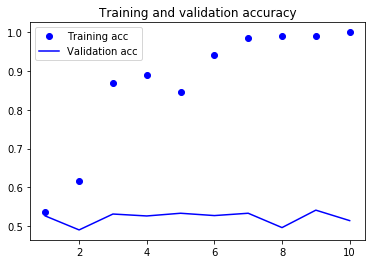

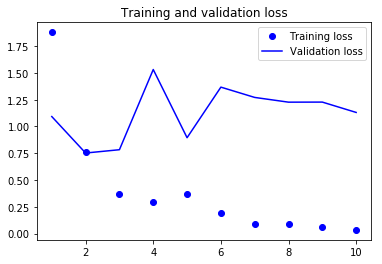

In [67]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()